## Proyecto de procesamiento de lenguaje natural
Estamos analizando: https://www.kaggle.com/competitions/feedback-prize-effectiveness/overview

### Preprocesamiento de datos

In [ ]:
# imports y configuración de paths
from pathlib import Path
import pandas as pd
import numpy as np
import re
import string

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"

PATH_TRAIN_CSV = DATA_DIR / "train.csv"
PATH_TEST_CSV = DATA_DIR / "test.csv"
PATH_SUB_CSV = DATA_DIR / "sample_submission.csv"

# Carpetas con ensayos en .txt
PATH_TRAIN_TXT = DATA_DIR / "train"
PATH_TEST_TXT  = DATA_DIR / "test"

print("Existe train.csv:", PATH_TRAIN_CSV.exists())
print("Existe test.csv:", PATH_TEST_CSV.exists())
print("Existe sample_submission.csv:", PATH_SUB_CSV.exists())
print("Dir train txt:", PATH_TRAIN_TXT, "| existe:", PATH_TRAIN_TXT.exists())
print("Dir test  txt:", PATH_TEST_TXT,  "| existe:", PATH_TEST_TXT.exists())


Existe train.csv: True
Existe test.csv: True
Existe sample_submission.csv: True
Dir train txt: data\train | existe: True
Dir test  txt: data\test | existe: True


In [ ]:
# cargar CSVs
train_df = pd.read_csv(PATH_TRAIN_CSV)
test_df  = pd.read_csv(PATH_TEST_CSV)
sub_df   = pd.read_csv(PATH_SUB_CSV)

print("train_df shape:", train_df.shape)
print("test_df  shape:", test_df.shape)
print("sample_submission shape:", sub_df.shape)
print("\nColumnas train:", list(train_df.columns))
print("Columnas test :", list(test_df.columns))

# Mostrar 3 filas para confirmar estructura
display(train_df.head(3))

# Distribución de clases (si está disponible)
if "discourse_effectiveness" in train_df.columns:
    print("\nDistribución de etiquetas en train:")
    print(train_df["discourse_effectiveness"].value_counts(dropna=False))


train_df shape: (36765, 5)
test_df  shape: (10, 4)
sample_submission shape: (10, 4)

Columnas train: ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']
Columnas test : ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type']


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate



Distribución de etiquetas en train:
discourse_effectiveness
Adequate       20977
Effective       9326
Ineffective     6462
Name: count, dtype: int64


train_df shape: (36765, 5) → Cada fila es un fragmento (discourse); hay 36,765 fragmentos.

test_df shape: (10, 4) → 10 fragmentos sin etiqueta (perfecto para pruebas locales).

### Cargar texto completo del ensayo (.txt) y unir por essay_id

In [ ]:
# funciones para leer ensayos y unir
def read_essay_text(essay_id: str, split="train") -> str:
    """
    Lee el .txt de un ensayo dado su essay_id.
    split: 'train' o 'test' para elegir carpeta.
    """
    folder = PATH_TRAIN_TXT if split == "train" else PATH_TEST_TXT
    path = folder / f"{essay_id}.txt"
    if not path.exists():
        return ""
    try:
        return path.read_text(encoding="utf-8")
    except UnicodeDecodeError:
        # fallback por si hay caracteres raros
        return path.read_text(encoding="latin-1", errors="ignore")

# Construimos un df con ensayo_id único y el texto
essays_train = (
    train_df[["essay_id"]]
    .drop_duplicates()
    .assign(essay_text=lambda d: d["essay_id"].apply(lambda x: read_essay_text(x, split="train")))
)

print("Ensayos únicos en train:", essays_train.shape[0])
display(essays_train.head(3))

# Unimos el texto completo del ensayo a cada fila del train (nivel de discourse)
train_df = train_df.merge(essays_train, on="essay_id", how="left")
print("train_df + essay_text:", train_df.shape)


Ensayos únicos en train: 4191


,essay_id,essay_text
0,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h..."
9,00944C693682,Limiting the usage of cars has personal and pr...
20,00BD97EA4041,Should computers read the emotional expression...


train_df + essay_text: (36765, 6)


Hay varios fragmentos por ensayo.

### Limpieza ligera del texto

In [ ]:
# limpieza ligera ===
PUNCT = string.punctuation.replace("'", "")  # conservamos comillas simples por si hay contracciones
PUNCT_RE = re.compile(f"[{re.escape(PUNCT)}]")

def normalize_whitespace(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def basic_clean(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    # reemplazar puntuación rara (dejamos apostrofes)
    s = PUNCT_RE.sub(" ", s)
    # remover caracteres no-ascii problemáticos
    s = s.encode("ascii", errors="ignore").decode("ascii")
    # espacios
    s = normalize_whitespace(s)
    return s

# Aplicamos a discourse_text y essay_text
train_df["discourse_text_clean"] = train_df["discourse_text"].apply(basic_clean)
train_df["essay_text_clean"]     = train_df["essay_text"].apply(basic_clean)

display(train_df[["discourse_text", "discourse_text_clean"]].head(3))


,discourse_text,discourse_text_clean
0,"Hi, i'm Isaac, i'm going to be writing about h...",hi i'm isaac i'm going to be writing about how...
1,"On my perspective, I think that the face is a ...",on my perspective i think that the face is a n...
2,I think that the face is a natural landform be...,i think that the face is a natural landform be...


### Features simples para EDA
Contamos palabras, oraciones (regex sencilla), densidad de puntuación, mayúsculas, y conectores lógicos.

In [ ]:
#  features simples
SENT_SPLIT_RE = re.compile(r"[.!?]+")
CONNECTORS = [
    "because","since","therefore","however","moreover","furthermore",
    "for example","for instance","in conclusion","on the other hand",
    "in addition","as a result","consequently","in contrast","thus"
]

def count_sentences(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    parts = [p.strip() for p in SENT_SPLIT_RE.split(text) if p.strip()]
    return len(parts)

def word_count(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def punct_density(raw: str) -> float:
    if not isinstance(raw, str) or not raw:
        return 0.0
    puncts = sum(1 for ch in raw if ch in string.punctuation)
    return puncts / max(1, len(raw))

def uppercase_ratio(raw: str) -> float:
    if not isinstance(raw, str) or not raw:
        return 0.0
    ups = sum(1 for ch in raw if ch.isupper())
    letters = sum(1 for ch in raw if ch.isalpha())
    return ups / max(1, letters)

def count_connectors(clean_text: str) -> int:
    if not isinstance(clean_text, str):
        return 0
    t = f" {clean_text} "
    return sum(t.count(f" {w} ") for w in CONNECTORS)

# Features a nivel de fragmento (discourse)
train_df["disc_words"]      = train_df["discourse_text_clean"].apply(word_count)
train_df["disc_sents"]      = train_df["discourse_text"].apply(count_sentences)
train_df["disc_avg_wps"]    = (train_df["disc_words"] / train_df["disc_sents"].replace(0, np.nan)).fillna(train_df["disc_words"])
train_df["disc_punctdens"]  = train_df["discourse_text"].apply(punct_density)
train_df["disc_upcase"]     = train_df["discourse_text"].apply(uppercase_ratio)
train_df["disc_connectors"] = train_df["discourse_text_clean"].apply(count_connectors)

# Features a nivel de ensayo (repetidas por fila para facilitar groupby en EDA)
train_df["essay_words"]      = train_df["essay_text_clean"].apply(word_count)
train_df["essay_sents"]      = train_df["essay_text"].apply(count_sentences)
train_df["essay_avg_wps"]    = (train_df["essay_words"] / train_df["essay_sents"].replace(0, np.nan)).fillna(train_df["essay_words"])
train_df["essay_punctdens"]  = train_df["essay_text"].apply(punct_density)
train_df["essay_upcase"]     = train_df["essay_text"].apply(uppercase_ratio)
train_df["essay_connectors"] = train_df["essay_text_clean"].apply(count_connectors)

cols_show = ["discourse_type","discourse_effectiveness","disc_words","disc_sents","disc_avg_wps","disc_connectors"]
display(train_df[cols_show].head(5))


,discourse_type,discourse_effectiveness,disc_words,disc_sents,disc_avg_wps,disc_connectors
0,Lead,Adequate,67,3,22.333333,0
1,Position,Adequate,41,2,20.500000,1
2,Claim,Adequate,21,1,21.000000,1
3,Evidence,Adequate,72,4,18.000000,1
4,Counterclaim,Adequate,18,1,18.000000,1


### Codificar etiquetas (para modelado posterior)

In [ ]:
# codificación de etiquetas
label_map = {"Ineffective":0, "Adequate":1, "Effective":2}
if "discourse_effectiveness" in train_df.columns:
    train_df["label"] = train_df["discourse_effectiveness"].map(label_map)
    print(train_df[["discourse_effectiveness","label"]].drop_duplicates().sort_values("label"))


  discourse_effectiveness  label
5             Ineffective      0
0                Adequate      1
9               Effective      2


In [ ]:
print(train_df["discourse_type"].value_counts())


discourse_type
Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: count, dtype: int64


### EDA

Metadatos

In [ ]:
print("Filas:", len(train_df))
print("Columnas:", list(train_df.columns))
print("Etiquetas:", train_df["discourse_effectiveness"].value_counts())
print("Tipos de discurso:", train_df["discourse_type"].value_counts())


Filas: 36765
Columnas: ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness', 'essay_text', 'discourse_text_clean', 'essay_text_clean', 'disc_words', 'disc_sents', 'disc_avg_wps', 'disc_punctdens', 'disc_upcase', 'disc_connectors', 'essay_words', 'essay_sents', 'essay_avg_wps', 'essay_punctdens', 'essay_upcase', 'essay_connectors', 'label']
Etiquetas: discourse_effectiveness
Adequate       20977
Effective       9326
Ineffective     6462
Name: count, dtype: int64
Tipos de discurso: discourse_type
Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: count, dtype: int64


Tabla cruzada tipo de discurso × efectividad

In [ ]:

ct = pd.crosstab(train_df["discourse_type"], train_df["discourse_effectiveness"], normalize="index").round(3)
display(ct)  # proporción por tipo


discourse_effectiveness,Adequate,Effective,Ineffective
discourse_type,,,
Claim,0.593,0.284,0.123
Concluding Statement,0.580,0.246,0.173
Counterclaim,0.649,0.236,0.116
Evidence,0.501,0.238,0.261
Lead,0.543,0.298,0.159
Position,0.692,0.191,0.117
Rebuttal,0.557,0.273,0.170


Longitudes por clase (palabras)

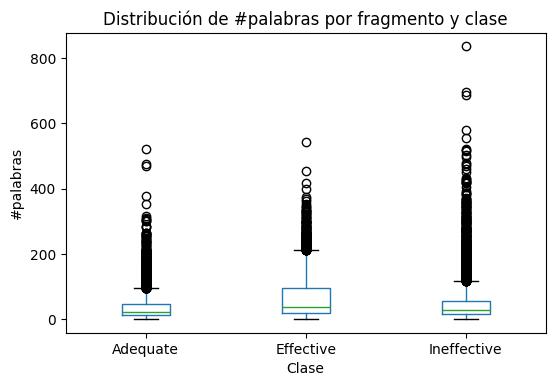

In [ ]:
import matplotlib.pyplot as plt
train_df.boxplot(column="disc_words", by="discourse_effectiveness", grid=False, figsize=(6,4))
plt.suptitle("")
plt.title("Distribución de #palabras por fragmento y clase")
plt.xlabel("Clase")
plt.ylabel("#palabras")
plt.show()

Conectores lógicos por clase

discourse_effectiveness
Ineffective    0.353451
Adequate       0.293941
Effective      0.531096
Name: disc_connectors, dtype: float64


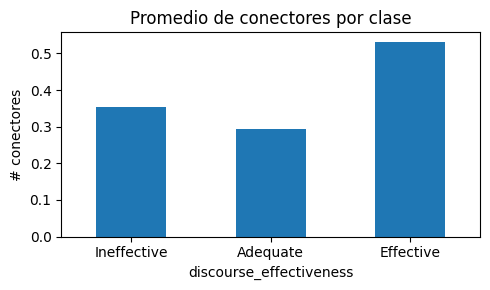

In [ ]:
means = train_df.groupby("discourse_effectiveness")["disc_connectors"].mean().reindex(["Ineffective","Adequate","Effective"])
print(means)
means.plot(kind="bar", figsize=(5,3), rot=0, title="Promedio de conectores por clase")
plt.ylabel("# conectores")
plt.tight_layout()
plt.show()


In [ ]:
das